# MERRA-2 Data Retrieval: 2m Temperature and VPD for United States

This notebook demonstrates how to:
1. Authenticate with NASA EarthData using earthaccess
2. Search for MERRA-2 hourly data collections
3. Filter data by date range and US bounding box
4. Retrieve 2m air temperature and vapor pressure deficit (VPD) data
5. List available variables in the dataset

In [1]:
# Import required libraries
import earthaccess
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

print("Libraries imported successfully")

Libraries imported successfully


## 1. Authenticate with NASA EarthData

You'll need a NASA EarthData account. Sign up at: https://urs.earthdata.nasa.gov/

The first time you run this, you'll be prompted to enter your credentials.

In [2]:
# Authenticate with NASA EarthData
auth = earthaccess.login()
print("Authentication successful!")

Authentication successful!


## 2. Define Parameters

### MERRA-2 Collections for Hourly Data:
- **M2T1NXSLV**: Single-Level Diagnostics (hourly, time-averaged)
  - Contains: T2M (2m air temperature), QV2M (2m specific humidity), PS (surface pressure), etc.
  
### US Bounding Box:
- Lower 48 states approximately: (-125°W to -66°W, 24°N to 49°N)
- Including Alaska and Hawaii: (-180°W to -66°W, 18°N to 72°N)

In [ ]:
# Define parameters
# US Bounding Box (Lower 48 + Alaska + Hawaii)
# bbox = (-180, 18, -66, 72)  # (min_lon, min_lat, max_lon, max_lat)

# For Lower 48 only, use:
bbox = (-125, 24, -66, 49)

# Date range
start_date = "1984-01-01"
end_date = "2025-12-31" 

# MERRA-2 collection short name for hourly single-level diagnostics
collection_id = "M2T1NXSLV"  # Version 5.12.4

print(f"Date range: {start_date} to {end_date}")
print(f"Bounding box: {bbox}")
print(f"Collection: {collection_id}")

Date range: 2023-06-01 to 2023-06-07
Bounding box: (-125, 24, -66, 49)
Collection: M2T1NXSLV


## 3. Search for MERRA-2 Data

In [8]:
# Search for granules
results = earthaccess.search_data(
    short_name=collection_id,
    bounding_box=bbox,
    temporal=(start_date, end_date),
)

print(f"Found {len(results)} granules")
print(f"\nFirst few granules:")
for i, granule in enumerate(results[:3]):
    print(f"  {i+1}. {granule['umm']['GranuleUR']}")

Found 7 granules

First few granules:
  1. M2T1NXSLV.5.12.4:MERRA2_400.tavg1_2d_slv_Nx.20230601.nc4
  2. M2T1NXSLV.5.12.4:MERRA2_400.tavg1_2d_slv_Nx.20230602.nc4
  3. M2T1NXSLV.5.12.4:MERRA2_400.tavg1_2d_slv_Nx.20230603.nc4


## 4. Download and Open Data

We'll download a subset of the data and open it with xarray.

In [9]:
# Download the first few files (or all if you want)
# For testing, let's use just the first file
files = earthaccess.open(results[:1])

print(f"Opened {len(files)} file(s)")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Opened 1 file(s)


In [10]:
# Open with xarray
ds = xr.open_mfdataset(files, combine='by_coords')

print("Dataset loaded successfully!")
print(f"\nDataset dimensions: {dict(ds.dims)}")
print(f"\nDataset coordinates: {list(ds.coords)}")

# Apply spatial subset
min_lon, min_lat, max_lon, max_lat = bbox

ds_us = ds.sel(
    lon=slice(min_lon, max_lon),
    lat=slice(min_lat, max_lat)
)

print(f"Original dataset shape: {ds.dims}")
print(f"US subset shape: {ds_us.dims}")
print(f"\nLatitude range: {float(ds_us.lat.min()):.2f} to {float(ds_us.lat.max()):.2f}")
print(f"Longitude range: {float(ds_us.lon.min()):.2f} to {float(ds_us.lon.max()):.2f}")

Dataset loaded successfully!

Dataset dimensions: {'lon': 576, 'lat': 361, 'time': 24}

Dataset coordinates: ['lon', 'lat', 'time']
Original dataset shape: FrozenMappingWarningOnValuesAccess({'lon': 576, 'lat': 361, 'time': 24})
US subset shape: FrozenMappingWarningOnValuesAccess({'lon': 95, 'lat': 51, 'time': 24})

Latitude range: 24.00 to 49.00
Longitude range: -125.00 to -66.25


/var/folders/jq/m05tkv2d1llbn0w9wc6cltyr0000gn/T/ipykernel_32473/107969004.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nDataset dimensions: {dict(ds.dims)}")


## 5. List All Available Variables

Let's explore what variables are available in the MERRA-2 M2T1NXSLV collection.

In [11]:
# Display all variables with descriptions
print("Available Variables in M2T1NXSLV Collection:")
print("=" * 80)

for var_name in ds_us.data_vars:
    var = ds_us[var_name]
    long_name = var.attrs.get('long_name', 'N/A')
    units = var.attrs.get('units', 'N/A')
    print(f"\n{var_name}:")
    print(f"  Description: {long_name}")
    print(f"  Units: {units}")
    print(f"  Dimensions: {var.dims}")
    print(f"  Shape: {var.shape}")

Available Variables in M2T1NXSLV Collection:

CLDPRS:
  Description: cloud_top_pressure
  Units: Pa
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

CLDTMP:
  Description: cloud_top_temperature
  Units: K
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

DISPH:
  Description: zero_plane_displacement_height
  Units: m
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

H1000:
  Description: height_at_1000_mb
  Units: m
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

H250:
  Description: height_at_250_hPa
  Units: m
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

H500:
  Description: height_at_500_hPa
  Units: m
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

H850:
  Description: height_at_850_hPa
  Units: m
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

OMEGA500:
  Description: omega_at_500_hPa
  Units: Pa s-1
  Dimensions: ('time', 'lat', 'lon')
  Shape: (24, 51, 95)

PBLTOP:
  Description: pbltop_pressure
  

## 6. Key Variables for Temperature and VPD Analysis

### Relevant Variables in M2T1NXSLV:

**For Temperature Analysis:**
- **T2M**: 2-meter air temperature (K)
- **T10M**: 10-meter air temperature (K)
- **TS**: Surface skin temperature (K)
- **T2MMAX**: Maximum 2-meter temperature (K)
- **T2MMIN**: Minimum 2-meter temperature (K)

**For VPD Calculation:**
- **T2M**: 2-meter air temperature (K) - needed for saturation vapor pressure
- **QV2M**: 2-meter specific humidity (kg/kg) - needed for actual vapor pressure
- **PS**: Surface pressure (Pa) - needed to convert specific humidity
- **RH2M**: 2-meter relative humidity (%) - alternative for VPD calculation

**VPD Formula:**
```
VPD = es - ea
where:
  es = saturation vapor pressure (calculated from T2M)
  ea = actual vapor pressure (calculated from QV2M and PS, or from RH2M)
```

In [12]:
# Extract key variables for our analysis
print("Extracting temperature and humidity variables...")

# Check which variables are available
available_vars = list(ds_us.data_vars)
print(f"\nVariables present in this dataset: {available_vars}")

Extracting temperature and humidity variables...

Variables present in this dataset: ['CLDPRS', 'CLDTMP', 'DISPH', 'H1000', 'H250', 'H500', 'H850', 'OMEGA500', 'PBLTOP', 'PS', 'Q250', 'Q500', 'Q850', 'QV10M', 'QV2M', 'SLP', 'T10M', 'T250', 'T2M', 'T2MDEW', 'T2MWET', 'T500', 'T850', 'TO3', 'TOX', 'TQI', 'TQL', 'TQV', 'TROPPB', 'TROPPT', 'TROPPV', 'TROPQ', 'TROPT', 'TS', 'U10M', 'U250', 'U2M', 'U500', 'U50M', 'U850', 'V10M', 'V250', 'V2M', 'V500', 'V50M', 'V850', 'ZLCL']


## 7. Extract and Process 2m Temperature

In [14]:
# Extract 2m temperature
if 'T2M' in ds_us:
    t2m = ds_us['T2M']
    
    # Convert from Kelvin to Celsius
    t2m_celsius = t2m - 273.15
    
    print("2m Temperature Statistics (Celsius):")
    print(f"  Mean: {float(t2m_celsius.mean()):.2f}°C")
    # print(f"  Min: {float(t2m_celsius.min()):.2f}°C")
    # print(f"  Max: {float(t2m_celsius.max()):.2f}°C")
    # print(f"  Std: {float(t2m_celsius.std()):.2f}°C")
else:
    print("T2M variable not found in dataset")

2m Temperature Statistics (Celsius):
  Mean: 20.71°C


## 8. Calculate Vapor Pressure Deficit (VPD)

VPD is calculated using the Clausius-Clapeyron equation and actual vapor pressure.

In [16]:
def calculate_vpd(temperature_k, specific_humidity, surface_pressure):
    """
    Calculate Vapor Pressure Deficit (VPD)
    
    Parameters:
    -----------
    temperature_k : xarray.DataArray
        Temperature in Kelvin
    specific_humidity : xarray.DataArray
        Specific humidity in kg/kg
    surface_pressure : xarray.DataArray
        Surface pressure in Pa
    
    Returns:
    --------
    vpd : xarray.DataArray
        Vapor pressure deficit in kPa
    """
    # Convert temperature to Celsius
    temp_c = temperature_k - 273.15
    
    # Calculate saturation vapor pressure (es) in kPa using Tetens formula
    es = 0.6108 * np.exp((17.27 * temp_c) / (temp_c + 237.3))
    
    # Calculate actual vapor pressure (ea) from specific humidity
    # ea = (q * P) / (0.622 + 0.378 * q)
    ea = (specific_humidity * surface_pressure) / (0.622 + 0.378 * specific_humidity)
    ea = ea / 1000  # Convert from Pa to kPa
    
    # Calculate VPD
    vpd = es - ea
    
    return vpd

# Calculate VPD if variables are available
if all(var in ds_us for var in ['T2M', 'QV2M', 'PS']):
    
    vpd = calculate_vpd(ds_us['T2M'], ds_us['QV2M'], ds_us['PS'])
    vpd.attrs['long_name'] = 'Vapor Pressure Deficit'
    vpd.attrs['units'] = 'kPa'
    
    print("VPD Statistics:")
    print(f"  Mean: {float(vpd.mean()):.2f} kPa")
    # print(f"  Min: {float(vpd.min()):.2f} kPa")
    # print(f"  Max: {float(vpd.max()):.2f} kPa")
    # print(f"  Std: {float(vpd.std()):.2f} kPa")
else:
    print("Required variables for VPD calculation not found")
    print(f"Available: {[v for v in ['T2M', 'QV2M', 'PS'] if v in ds]}")

VPD Statistics:
  Mean: 0.85 kPa


## 9. Visualize Sample Data

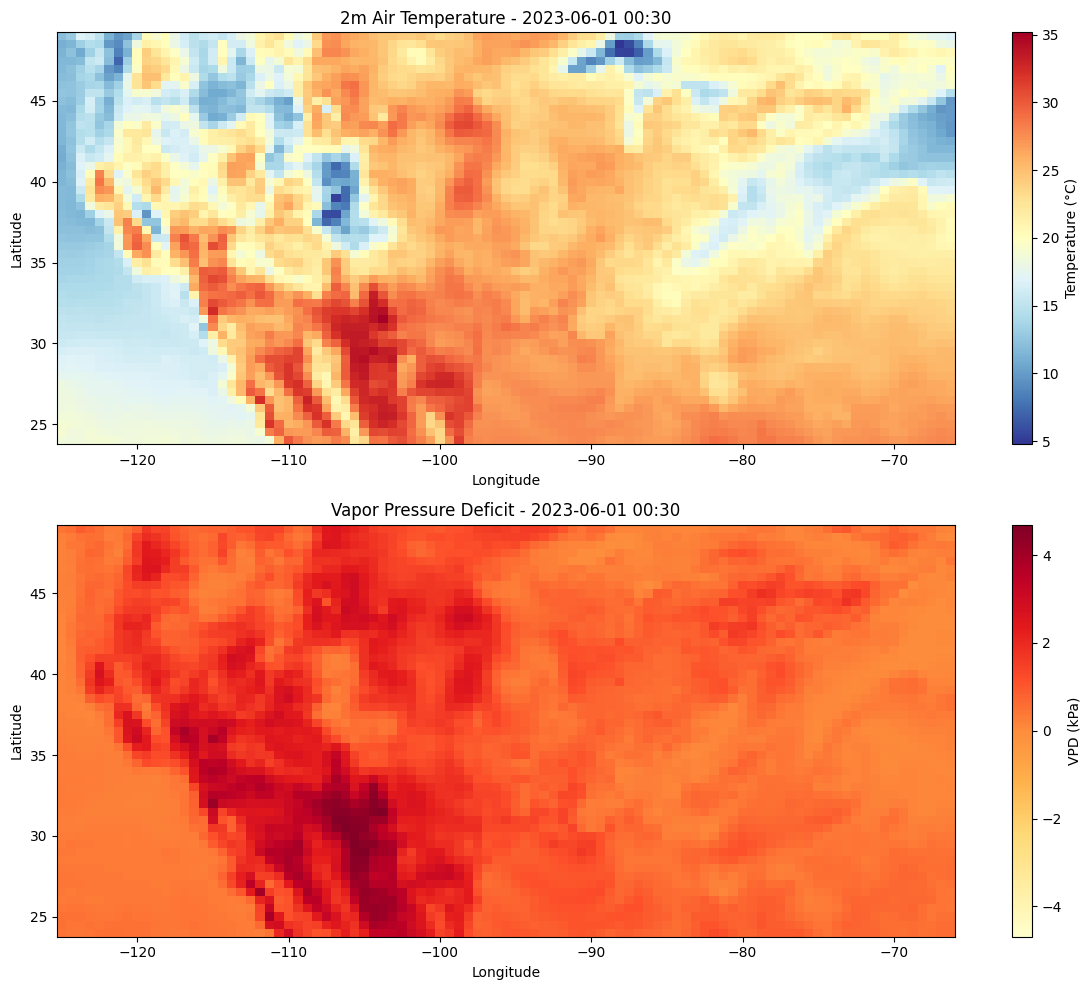

In [17]:
# Plot temperature and VPD for first time step
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Temperature plot
temp_plot = (t2m_celsius.isel(time=0)).plot(
    ax=axes[0],
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)'}
)
axes[0].set_title(f"2m Air Temperature - {pd.Timestamp(ds_us.time.values[0]).strftime('%Y-%m-%d %H:%M')}")
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# VPD plot (if calculated)
if all(var in ds_us for var in ['T2M', 'QV2M', 'PS']):
    # vpd_us = calculate_vpd(ds_us['T2M'], ds_us['QV2M'], ds_us['PS'])
    vpd_plot = vpd.isel(time=0).plot(
        ax=axes[1],
        cmap='YlOrRd',
        cbar_kwargs={'label': 'VPD (kPa)'}
    )
    axes[1].set_title(f"Vapor Pressure Deficit - {pd.Timestamp(ds_us.time.values[0]).strftime('%Y-%m-%d %H:%M')}")
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


## 11. Time Series Analysis

KeyboardInterrupt: 

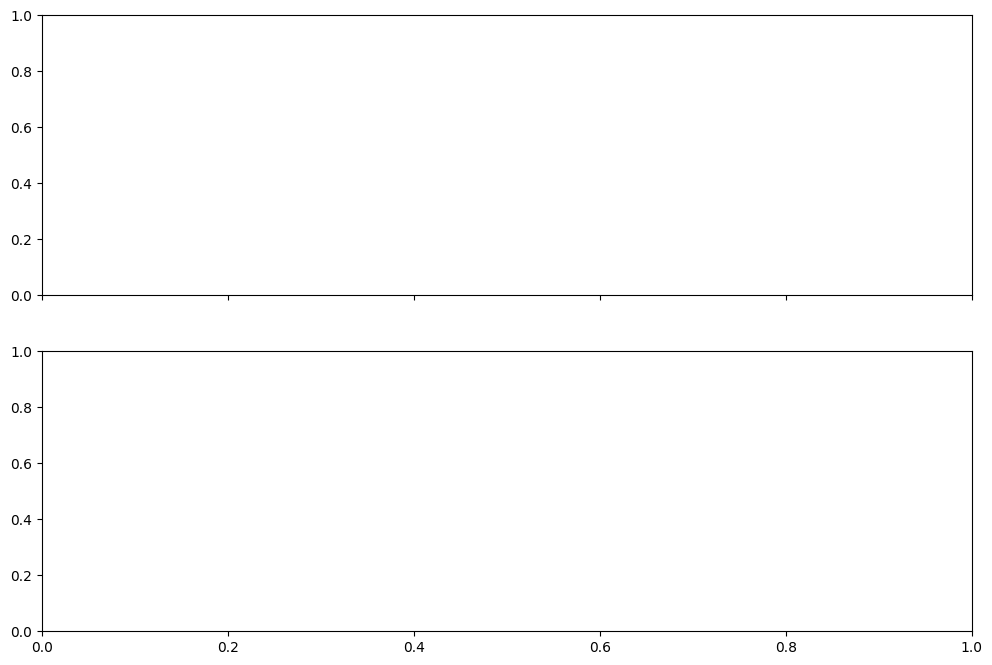

In [18]:
# Calculate spatial mean over US region for time series
if 'T2M' in ds_us:
    t2m_timeseries = (ds_us['T2M'] - 273.15).mean(dim=['lat', 'lon'])
    
    if all(var in ds_us for var in ['T2M', 'QV2M', 'PS']):
        vpd_us = calculate_vpd(ds_us['T2M'], ds_us['QV2M'], ds_us['PS'])
        vpd_timeseries = vpd_us.mean(dim=['lat', 'lon'])
        
        # Plot time series
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Temperature time series
        t2m_timeseries.plot(ax=axes[0], color='red', linewidth=2)
        axes[0].set_title('Mean 2m Temperature over US')
        axes[0].set_ylabel('Temperature (°C)')
        axes[0].grid(True, alpha=0.3)
        
        # VPD time series
        vpd_timeseries.plot(ax=axes[1], color='orange', linewidth=2)
        axes[1].set_title('Mean VPD over US')
        axes[1].set_ylabel('VPD (kPa)')
        axes[1].set_xlabel('Time')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        # Just plot temperature
        fig, ax = plt.subplots(figsize=(12, 4))
        t2m_timeseries.plot(ax=ax, color='red', linewidth=2)
        ax.set_title('Mean 2m Temperature over US')
        ax.set_ylabel('Temperature (°C)')
        ax.set_xlabel('Time')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Cannot create time series - required variables not available")

## 12. Summary of Variables for Temperature and VPD

### Primary Variables (M2T1NXSLV Collection):

| Variable | Description | Units | Use Case |
|----------|-------------|-------|----------|
| **T2M** | 2-meter air temperature | K | Primary temperature variable |
| **T10M** | 10-meter air temperature | K | Atmospheric boundary layer studies |
| **TS** | Surface skin temperature | K | Land surface temperature |
| **QV2M** | 2-meter specific humidity | kg/kg | VPD calculation (actual vapor pressure) |
| **PS** | Surface pressure | Pa | VPD calculation (humidity conversion) |
| **RH2M** | 2-meter relative humidity | % | Alternative VPD calculation |
| **T2MMAX** | Maximum 2-meter temperature | K | Daily extremes |
| **T2MMIN** | Minimum 2-meter temperature | K | Daily extremes |
| **U2M** | 2-meter eastward wind | m/s | Heat stress indices |
| **V2M** | 2-meter northward wind | m/s | Heat stress indices |
| **TLML** | Temperature at PBL top | K | Boundary layer analysis |

### Data Characteristics:
- **Temporal Resolution**: Hourly (time-averaged)
- **Spatial Resolution**: 0.625° longitude × 0.5° latitude
- **Time Coverage**: 1980-present (with ~2-3 month latency)
- **Collection**: M2T1NXSLV v5.12.4

In [ ]:
# Display dataset info
print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
ds_us.info()

## 13. Save Processed Data (Optional)

In [ ]:
# Optionally save the processed data to NetCDF
# Uncomment to save:

# output_file = "merra2_us_temp_vpd_processed.nc"
# ds_us.to_netcdf(output_file)
# print(f"Data saved to {output_file}")